<h2>Two Input Networks Using Categorical Embeddings, Shared Layers, & Merge Layers
</h2>

In [9]:
import warnings
warnings.filterwarnings( 'ignore' )

import os
import gc
import joblib
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as klyr
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option( 'display.max_rows', 8 )
pd.set_option( 'display.max_columns', None )

<h3>Category Embeddings</h3>

`Category Embedding` are advanced NN layer function, used for dealing with high cadinality cateogrical data.

###### Define team model

The team strength lookup has 3 components:
- an input
- an embedding layer and
- a flatten layer that creates the output.

If we wrap these 3 layers in a model with an input & output, we can re-use that stack of 3 layers at multiple places.

Note again that the weights for all 3 layers will be shared everywhere we use them.

In [3]:
sgame_df = pd.read_csv( r'datasets\games_season.csv' )
print( sgame_df.shape );  sgame_df.head()

(312178, 8)


,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [4]:
sgame_df['team_1'].nunique()

10888

In [5]:
# Create an embedding layer that maps each team ID to a single number representing that team's strength.
embedLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  # each team is represented as a single integer, use an input length of 1
                             output_dim= 1,  # to produce a single team strength rating use an output dimension of 1
                             name= 'team-strength-embedding-model'   )
# The input length should be 1 dimension (as each team is represented by exactly one id)
# The output shape should be 1 dimension (as we want to represent the teams by a single number)

In [6]:
# Create a 1D input tensor layer for the team ID (which will be an integer)
inputTnsr = klyr.Input(  shape= ( 1, )  )
# Pass this input tensor to the embededLyr Team lookup layer that was created previously
embTnsr = embedLyr( inputTnsr )

In [7]:
## Embedding layers increase the dim of the data. The input CSV has two dimensions (rows & columns),
# but embedding layers add a 3rd dim. This 3rd dim is useful when dealing with images and text, so it is not as relevant for this dataset.
# Therefore, we use the flatten layer to flatten the embeddings from 3D to 2D.
y_embTnsr_flat = klyr.Flatten()( embTnsr )

print( f'embTnsr --> {embTnsr.shape}  \n\ny_embTnsr_flat --> {y_embTnsr_flat.shape}' )

embTnsr --> (None, 1, 1)  

y_embTnsr_flat --> (None, 1)


In [8]:
## all steps (repeatative)
inputTnsr = klyr.Input(  shape= ( 1, )  )
embedLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  output_dim= 1, name= 'team-strength-embedding-model'   )
embTnsr = embedLyr( inputTnsr )
y_embTnsr_flat = klyr.Flatten()( embTnsr )

In [9]:
kModel1 = keras.Model(  inputs= inputTnsr, outputs= y_embTnsr_flat )
kModel1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 team-strength-embedding-mod  (None, 1, 1)             10888     
 el (Embedding)                                                  
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


Model: "team-strength-embedding-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 team-strength-embedding-lyr  (None, 1, 1)             10888     
  (Embedding)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


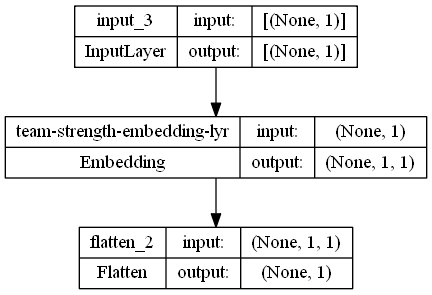

In [10]:
## all at once (repeated)
inputTnsr = klyr.Input( shape= (1,) )
embedFuncLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  # each team is represented as a single integer, use an input length of 1
                             output_dim= 1,  # to produce a single team strength rating use an output dimension of 1
                             name= 'team-strength-embedding-lyr'
                         )
y_embTnsr = embedFuncLyr( inputTnsr )
y_embTnsr_flat = klyr.Flatten()( y_embTnsr )

kModel1 = keras.Model(  inputs= inputTnsr, outputs= y_embTnsr_flat, name= 'team-strength-embedding-model'  )

kModel1.summary()
keras.utils.plot_model( kModel1, show_shapes= True,  show_layer_activations= True )

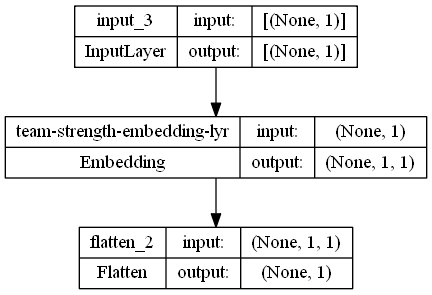

In [11]:
keras.utils.plot_model( kModel1, show_shapes= True,  show_layer_activations= True )

<br>

### Category Embeddings for AirBnB data


`Categorical entity embedding` extracts the embedding layers of categorical variables from a neural network model, and uses numeric vectors to represent the properties of the categorical values. It is usually used on categorical variables with high cardinalities. 

For example, a marketing company can create categorical entity embedding for different campaigns to represent the characteristics using vectors, and use those vectors to understand the similarities between campaigns, or put the vectors as features into different machine learning models to improve the model performance.

Here we are using Tensorflow Keras to create categorical entity embeddings of Airbnb neighbourhood data.

<br>

##### Data download

A website called Inside Airbnb had the Airbnb data publicly available for research. We used the listing data for Washington D.C. for this analysis.

Download the data:
1. Go to: http://insideairbnb.com/get-the-data
2. Scroll down the page until you see the section called **Washington, D.C., District of Columbia, United States**. 
3. Click the blue file name "listings.csv" to download the data.

The listing data has the property information aggregated at the listing ID level. We will build a simple model to predict the listing price, and the following columns will be read from the dataset.
* `id` is the unique ID for the Airbnb listing.
* `neighbourhood` is the neighbourhood name where the listing is located.
* `room_type` is the type of the room. It can be the entire house, a room in a house, etc.
* `price` is the daily price in local currency. Washington D.C. is in the United States, so the currency for the price is US dollars.
* `minimum_nights` is the listing's minimum number of nights for the stay.
* `number_of_reviews` is the total number of reviews for the listing.
* `reviews_per_month` is the average number of reviews per month.
* `calculated_host_listings_count` is the total number of listings that the host has in Washington D.C.
* `availability_365` is the availability of the listing in the next 365 days. The listing can be unavailable because of the guest booking or the host blocking.
* `number_of_reviews_ltm` is the number of reviews in the last 12 months.

In [ ]:
# List of concerned columns 
cols_to_keep = [  'id', 'neighbourhood', 'room_type', 'price',  'minimum_nights',  'number_of_reviews', 
                  'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm'  ]
air_df = pd.read_csv(  r'datasets\airbnb_listings_dc_20020914.csv',
                          usecols= cols_to_keep )

air_df.head()

,id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,3686,Historic Anacostia,Private room,67,31,83,0.53,1,271,2
1,3943,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,78,1,480,2.75,5,334,37
2,4197,"Capitol Hill, Lincoln Park",Private room,80,7,56,0.32,2,331,10
3,4529,"Eastland Gardens, Kenilworth",Private room,56,30,102,0.59,1,179,0
4,4967,"Ivy City, Arboretum, Trinidad, Carver Langston",Private room,2500,1125,31,0.20,3,365,0


In [4]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6705 entries, 0 to 6704
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6705 non-null   int64  
 1   neighbourhood                   6705 non-null   object 
 2   room_type                       6705 non-null   object 
 3   price                           6705 non-null   int64  
 4   minimum_nights                  6705 non-null   int64  
 5   number_of_reviews               6705 non-null   int64  
 6   reviews_per_month               5323 non-null   float64
 7   calculated_host_listings_count  6705 non-null   int64  
 8   availability_365                6705 non-null   int64  
 9   number_of_reviews_ltm           6705 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 524.0+ KB


Let's consider `neighbourhood` as Categorical. Then, we can say that, 2 out of the 10 columns are categorical i.e. `neighbourhood` & `room_type`. Most of the columns do not have missing data. Only the variable `reviews_per_month` has missing data and needs missing imputation.

In [5]:
air_df[ air_df['reviews_per_month'].isnull() ]['number_of_reviews'].value_counts()
'''
We can see that all the listings with missing values have zero reviews. Therefore, we need to impute the missing values to zeros.
'''

'\nWe can see that all the listings with missing values have zero reviews. Therefore, we need to impute the missing values to zeros.\n'

In [6]:
# Impute the missing values for reviews_per_month to 0
air_df['reviews_per_month'] = air_df['reviews_per_month'].fillna(0)

In [8]:
print(  f'The minimum price is {air_df.price.min()} and the maximum price is {air_df.price.max()}.'  )
# The price range shows that the minimum price is 0 and the maximum price is 10,000.
# let's remove the outlier prices and only keep the listings with a daily price greater than 20 dollars and less than 1000 dollars.
air_df = air_df[  (air_df['price']>20) & (air_df['price']<1000) ].reset_index( drop= True )
print(  f'The minimum price is {air_df.price.min()} and the maximum price is {air_df.price.max()}.'  )
air_df.head()

The minimum price is 22 and the maximum price is 999.


,id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,3686,Historic Anacostia,Private room,67,31,83,0.53,1,271,2
1,3943,"Edgewood, Bloomingdale, Truxton Circle, Eckington",Private room,78,1,480,2.75,5,334,37
2,4197,"Capitol Hill, Lincoln Park",Private room,80,7,56,0.32,2,331,10
3,4529,"Eastland Gardens, Kenilworth",Private room,56,30,102,0.59,1,179,0
4,5589,"Kalorama Heights, Adams Morgan, Lanier Heights",Entire home/apt,59,31,96,0.56,1,27,1


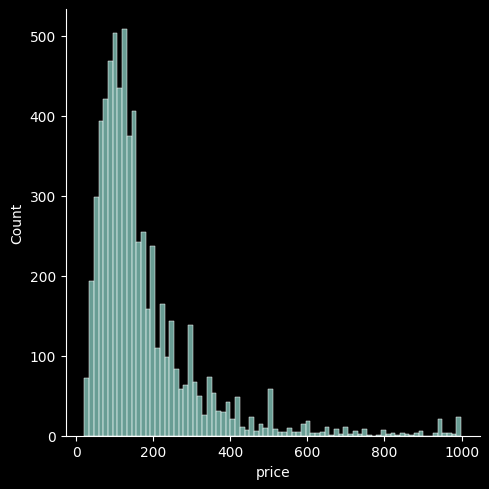

In [13]:
# Visualization
plt.style.use( 'dark_background'  )
sns.displot(  air_df['price'] )

In [83]:
air_df['room_type']

0          Private room
1          Private room
2          Private room
3          Private room
4       Entire home/apt
             ...       
6616       Private room
6617       Private room
6618    Entire home/apt
6619    Entire home/apt
6620       Private room
Name: room_type, Length: 6621, dtype: object

In [90]:
air_df['room_type'] = air_df['room_type'].astype( 'category' )

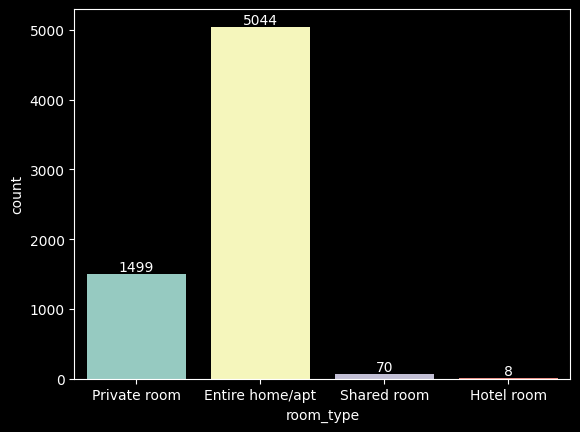

In [15]:
# room_type categories
ax = sns.countplot( data= air_df, x= 'room_type' )
ax.bar_label( ax.containers[0] ) 
plt.show()

In [20]:
# Since the number of categories is small for `room_type`, we will not do entity embeddings.
# Instead, we will use `get_dummies` to create a dummy variable with 0 & 1 values for each category.
air_df = (  air_df
     .pipe(    lambda df: df.assign(   room_type = df['room_type'].replace(  { 'Private room':'private', 'Entire home/apt':'entireUnit', 'Shared room':'sharedRoom', 'Hotel room':'hotelRoom' }  )   )    )
     .pipe(    lambda df: pd.concat(  [ df, pd.get_dummies( df['room_type'] ) ], axis= 'columns'   )    )
     .drop( columns= 'room_type', errors= 'ignore' )
)
air_df.head()


,id,neighbourhood,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,entireUnit,hotelRoom,private,sharedRoom
0,3686,Historic Anacostia,67,31,83,0.53,1,271,2,0,0,1,0
1,3943,"Edgewood, Bloomingdale, Truxton Circle, Eckington",78,1,480,2.75,5,334,37,0,0,1,0
2,4197,"Capitol Hill, Lincoln Park",80,7,56,0.32,2,331,10,0,0,1,0
3,4529,"Eastland Gardens, Kenilworth",56,30,102,0.59,1,179,0,0,0,1,0
4,5589,"Kalorama Heights, Adams Morgan, Lanier Heights",59,31,96,0.56,1,27,1,1,0,0,0


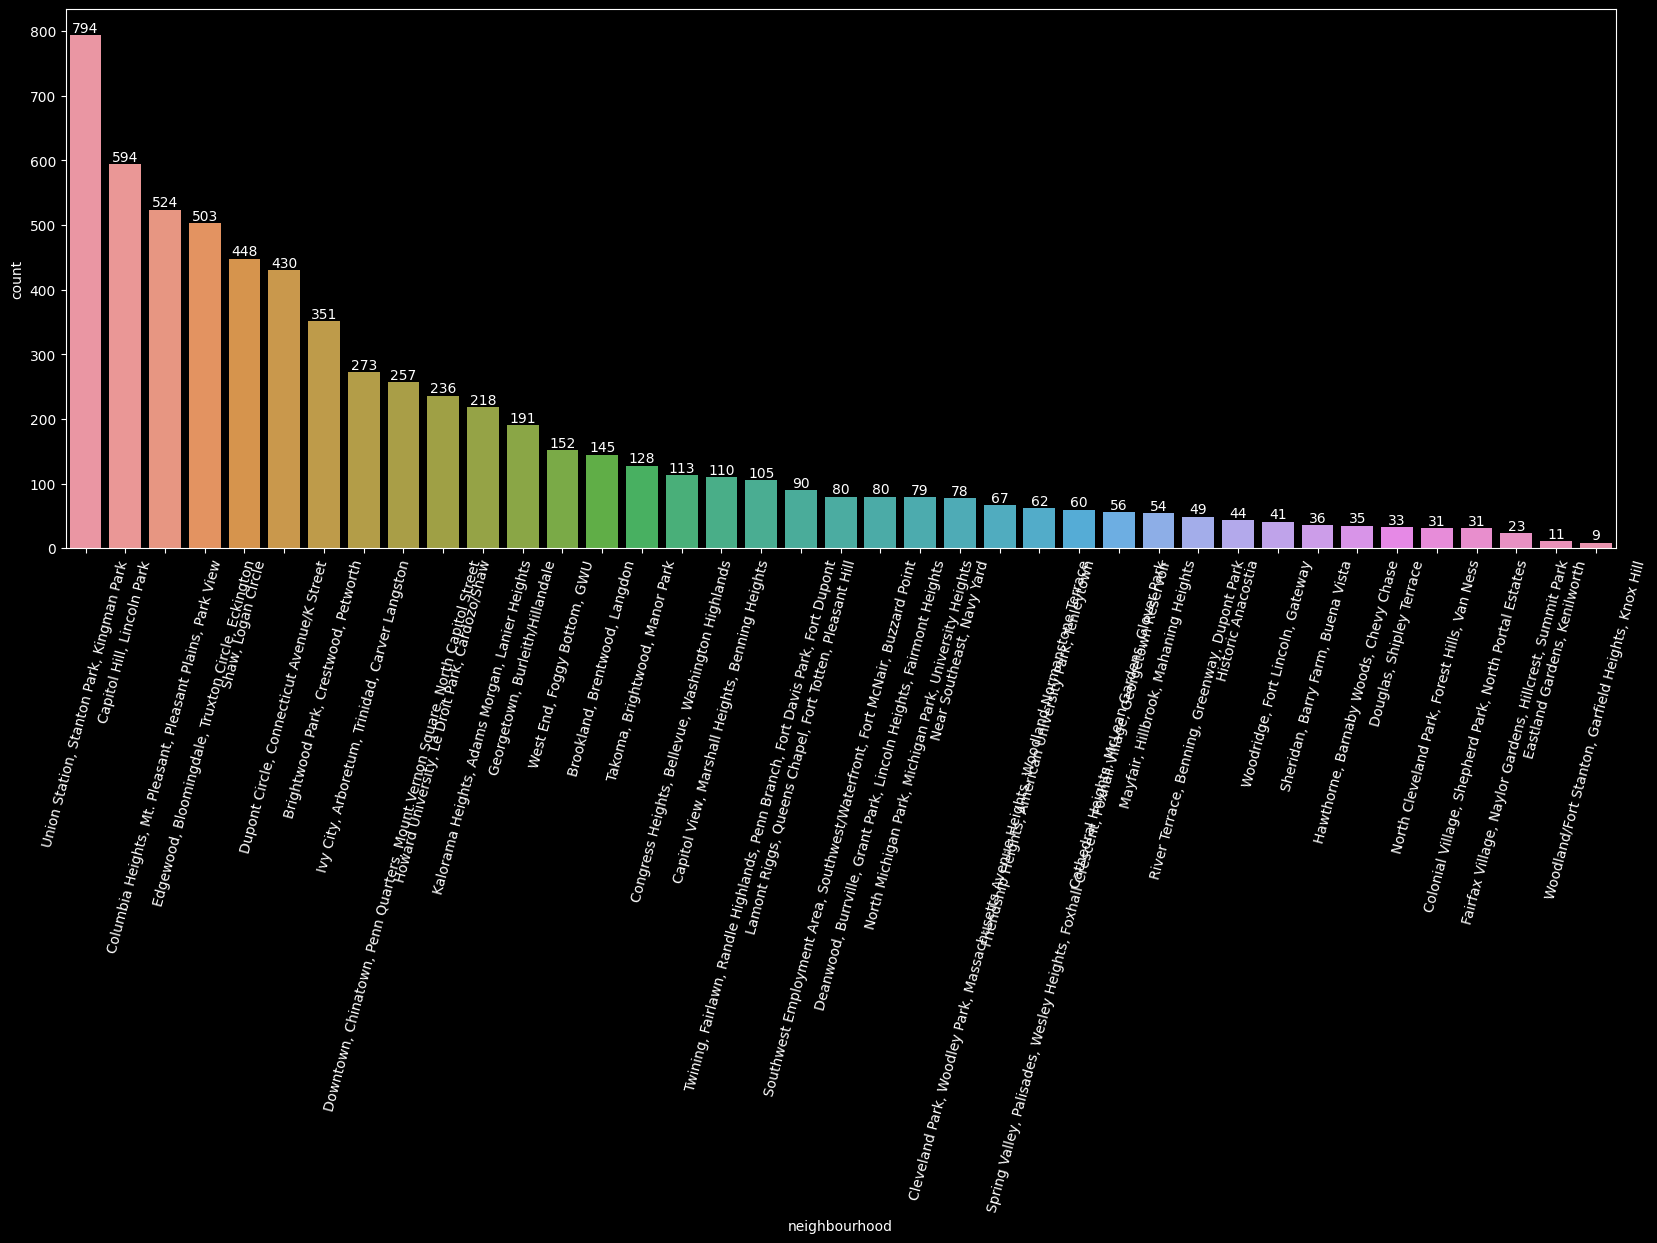

In [26]:
## Neighborhood distribution
fg, ax = plt.subplots( 1,1, figsize= (20, 7) )
sns.countplot(  data= air_df, x= 'neighbourhood', order= air_df['neighbourhood'].value_counts().index, ax= ax  )
# Add labels
ax.bar_label( ax.containers[0] )
# Rotate x labels
ax.tick_params(  axis= 'x', rotation= 75  )  


##### Train test split
* `x` has all the features for the model prediction.
* `y` is the target variable. We are predicting the daily listing prices, so the column `price` is used as the target.


In [33]:
import sklearn.model_selection
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  air_df.drop( columns= [ 'id', 'price' ] ),
                                      air_df['price'], test_size= 20./100, random_state= 42   )

print(  f'''The training dataset has shape --> {xtrn.shape}
The y label have shape --> {ytrn.shape}''' )

The training dataset has shape --> (5296, 11)
The y label have shape --> (5296,)


### `categorical label encoding` for the *`neighbourhood`* variable.

In [125]:
catEncoder_dictn = {   eNeigh:idx  for idx, eNeigh in enumerate(  sorted(xtrn['neighbourhood'].unique())  )   }

[  print( f'{eKey} : {eVal}' )  for eKey, eVal in catEncoder_dictn.items() if eVal < 5 ];

Brightwood Park, Crestwood, Petworth : 0
Brookland, Brentwood, Langdon : 1
Capitol Hill, Lincoln Park : 2
Capitol View, Marshall Heights, Benning Heights : 3
Cathedral Heights, McLean Gardens, Glover Park : 4


In [107]:
xtrn_NeighborMap_arr = xtrn['neighbourhood'].map( catEncoder_dictn ).values
xtst_NeighborMap_arr = xtst['neighbourhood'].map( catEncoder_dictn ).values
print( type(xtrn_NeighborMap_arr),'\n\n', xtrn_NeighborMap_arr, '\n', xtst_NeighborMap_arr )

'''we can observe that the list for the training and testing dataset now has arrays of numbers representing the neighbourhoods'''

<class 'numpy.ndarray'> 

 [21  7  7 ... 27  1 20] 
 [36 38  0 ... 29 12 24]


'we can observe that the list for the training and testing dataset now has arrays of numbers representing the neighbourhoods'

#### Let's build a model with categorical entity embedding.

Firstly, let's create the embedding layer using the `Embedding` function.

* `input_dim` is the number of unique values for the categorical column. In this example, it is the number of unique neighbourhood.
* `output_dim` is the dimension of the embedding output. How to decide this number? The authors of the [entity embedding paper](https://arxiv.org/pdf/1604.06737.pdf) mentioned that it is a *hyperparameter* value to tune with the range of [1, no. of categories - 1]. The authors proposed 2 general guidelines:
    * If the number of aspects to describe the entities can be estimated, we can use that as the `output_dim`. More complex entities usually need more output dimensions. For example, `neighbourhood` can be described by population density, distance to major tour locations, convenience level, number of Airbnb listings, and safety index, so we set 5 as the number of output dimensions.
    * If the number of aspects to describe the entities cannot be estimated, then start with the highest possible number of dimensions, which = no. of categories - 1 for the hyperparameter tuning.
* `name` gives a name for the layer.
* The input dimension of the categorical variable is defined by the `Input` function. `Input()` is used to instantiate a Keras tensor. `shape=(1,)` indicates that the expected input will be a one-dimensional vector.
* `Reshape` changed the output from 3-dimensional to 2-dimensional.

In [173]:
input_dim = xtrn['neighbourhood'].nunique()
output_dim = 5

input_CatTnsr = klyr.Input( shape= (1,) )
embed_catTnsr = klyr.Embedding(  input_dim= input_dim, output_dim= output_dim, name= 'embeddingLyr_location'  )( input_CatTnsr )
embed_catTnsr

<KerasTensor: shape=(None, 1, 5) dtype=float32 (created by layer 'embeddingLyr_location')>

Flatten to reduce the dimension: `shape = (None, 1, 5)` --> `shape = (None, 5)`

Embedding layers increase the dimensionality of the data. The xtrn has 2 dimensions (rows & columns), but embedding layers add a 3rd dimension. This 3rd  dimension can be useful when dealing with images & text, so it is not as relevant to our dataset. Therefore, we use the `flatten layer `to flatten the embeddings from 3D to 2D.

The flatten layer is also the output layer for the embedding process. Flatten layers are an layer for deep learning models and can be used to transform data from multiple dimensions back down to 2 dimensions. They are useful for dealing with time series data, text data, & images. 

In [174]:
## either use Reshape OR Flatten
# embed_catTnsr = klyr.Reshape(  target_shape= (output_dim, )  )( embed_catTnsr )
# OR
embed_catTnsr = klyr.Flatten()( embed_catTnsr )
embed_catTnsr

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'flatten_9')>

In [145]:
xtrn.drop( columns= 'neighbourhood' ).values
xtst.drop( columns= 'neighbourhood' ).values

array([[ 31.  , 168.  ,   1.53, ...,   0.  ,   0.  ,   0.  ],
       [  2.  ,  99.  ,   1.22, ...,   0.  ,   0.  ,   0.  ],
       [  3.  , 116.  ,   1.55, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [ 31.  ,   6.  ,   0.38, ...,   0.  ,   0.  ,   0.  ],
       [  1.  ,   7.  ,   2.59, ...,   0.  ,   0.  ,   0.  ],
       [  3.  ,   3.  ,   0.73, ...,   0.  ,   1.  ,   0.  ]])

In [165]:
# input dim of the numeric features
input_numTnsr = klyr.Input(   shape= ( xtrn.drop( columns= 'neighbourhood' ).shape[1],  )  )
# output dim of the numeric features
embed_numTnsr = input_numTnsr 
input_numTnsr

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_10')>

In [164]:
inputTnsr = [ input_CatTnsr, input_numTnsr ]
print( f'{inputTnsr}' )

print('''\nThe input Keras tensors for both the categorical and the numeric variables are put in a list called `inputTnsr`.
`inputTnsr` shows that the first element has an input dimension of 1 and the second element has an input dimension of 10.''')

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_8')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_9')>]

The input Keras tensors for both the categorical and the numeric variables are put in a list called `inputTnsr`.
`inputTnsr` shows that the first element has an input dimension of 1 and the second element has an input dimension of 10.


Similarly, the output Keras tensors for both the categorical and the numeric variables are put in a list called `emb_data`. `emb_data` shows that the first element has an output dimension of 5 and the second element has an output dimension of 10.
* The categorical variable `neighbourhood` has a dimension of 5 because we manually specified the embedding dimension to be 5 in the embedding layer.
* The numeric variables have a dimension of 10 because there are 10 numeric columns.

In [175]:
embTnsr = [  embed_catTnsr, embed_numTnsr  ]
print( f'{embTnsr}' )

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'flatten_9')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'input_10')>]


In [177]:
# Using the `Concatenate()` function, the Keras tensors in the list `emb_data` are concatenated together.
# The output Keras tensor has a dimension of 15, which is the sum of the dimension of the two tensors in the list.
modelInputTnsr = klyr.Concatenate()( embTnsr )
modelInputTnsr

<KerasTensor: shape=(None, 15) dtype=float32 (created by layer 'concatenate_1')>

### Shared layers

Shared layers allow to define an operation and then apply the exact same operation (with the exact same weights) on different inputs.

In this model, we will share team rating for both inputs. The learned rating will be the same, whether it applies to team 1 or team 2.

<h3><p style= text-align:left;'>Shared Layer</p></h3>
<img src= 'images/shared_lyr.jpg' style= 'width:512px;height:297px;'>
<!-- # m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

[Go to top](#toc)

In [12]:
## input tensr lyrs
inputTnsr1 = klyr.Input( shape= (1,), name= 'inputLyr_team1' )
inputTnsr2 = klyr.Input( shape= (1,), name= 'inputLyr_team2' )

## Dense layr (to be shared by multiple inputs)
denseFuncLyr = klyr.Dense( units= 1 )

# y output Tensor
y_Tnsr1 = denseFuncLyr( inputTnsr1 )
y_Tnsr2 = denseFuncLyr( inputTnsr2 )

<br>
<div id= '6.2.5'>
</div>

### 6.2.5 Shared Model

Sharing multiple layers as a model

Using Keras API, we can also share models, not just layers. 
We can share the previously designed `category embedding model` where the model first embeds an input and then flattens it.

We can define modular components of models and then reuse them. We define an embedding layer and wrap it in a model. We then define 2 input tensors, and pass each one to the same model, producing 2 output tensors. This will use the same model, with the same layers and the same weights, for mapping each input to its corresponding output.

In other words, we can take an arbitrary sequence of keras layers, and wrap them up in a model. Once we have a model, we can re-use that model to share that sequence of steps for different input layers. 

<h3><p style= text-align:left;'>Shared Model</p></h3>
<img src= 'images/shared_model.jpg' style= 'width:516px;height:325px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

[Go to top](#toc)

In [13]:
## model to be shared later
inputTnsr = klyr.Input( shape= (1,) )
embedFuncLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  # each team is represented as a single integer, use an input length of 1
                                 output_dim= 1,  # to produce a single team strength rating use an output dimension of 1
                                 name= 'teamStrength_embdLyr'
                             )
y_embTnsr = klyr.Flatten()( embedFuncLyr( inputTnsr ) )

kEmbTeamStrength_model = keras.Model(  inputs= inputTnsr, outputs= y_embTnsr, name= 'teamStrength_embdModel'  )

Model: "teamStrength_embdModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 teamStrength_embdLyr (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


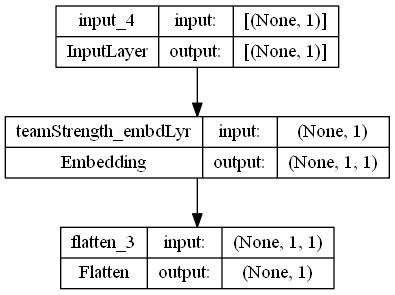

In [14]:
kEmbTeamStrength_model.summary(); keras.utils.plot_model( kEmbTeamStrength_model, show_shapes= True,  show_layer_activations= True )

Lookup both inputs in the same model

Now that we have a team strength model (`kEmbTeamStrength_model`) and an input layer for each team, we can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

This dataset have 10,888 unique teams. We want to learn a strength rating for each team, such that if any pair of teams plays each other, we can predict the score, even if those two teams have never played before. Furthermore, we want the strength rating to be the same, regardless of whether the team is the home team or the away team.

To achieve this, we use a shared layer, defined by the re-usable model (`kEmbTeamStrength_model()`) and the two input layers (`inputTnsr1` & `inputTnsr2`).

In [97]:
## input tensr lyrs for team 1 & 2 resp
inputTnsr1 = klyr.Input( shape= (1,), name= 'inputLyr_team1' )
inputTnsr2 = klyr.Input( shape= (1,), name= 'inputLyr_team2' )

## use the kEmbTeamStrength_model for both teams inputs
team1_Tnsr =  kEmbTeamStrength_model( inputTnsr1 )
team2_Tnsr =  kEmbTeamStrength_model( inputTnsr2 )

<br>

### Merge Tensors, Merge layers made from Shared Model

#### Add, Substract, multiply, Concatenate the input Tensor frames
Now that we've got multiple inputs & a shared layer, we need to combine the inputs into a single layer that we can use to predict a single output. This requires a `Merge layer`. `Merge layers` allow to define advanced, *non-sequential network topologies*. This can give a Data Scientist a lot of flexibility to creatively design networks to solve specific problems. 

<h3><p style= text-align:left;'>Merge Model</p></h3>
<img src= 'images/merge_lyrs.png' style= 'width:837px;height:450px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

[Go to top](#toc)

In [31]:
## model to be shared later (repeat)
inputGeneralTnsr = klyr.Input( shape= (1,), name= 'GeneralInputTnsr' )
embedFuncLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  # each team is represented as a single integer, use an input length of 1
                                 output_dim= 1,  # to produce a single team strength rating use an output dimension of 1
                                 name= 'teamStrength_embdLyr'
                             )
y_embTnsr = embedFuncLyr( inputGeneralTnsr )
y_embTnsr_flat = klyr.Flatten()( y_embTnsr )

kEmbTeamStrength_model = keras.Model(  inputs= inputGeneralTnsr, outputs= y_embTnsr_flat, name= 'kEmbTeamStrength_model'  )
# kEmbTeamStrength_model.summary(); keras.utils.plot_model( kEmbTeamStrength_model, show_shapes= True,  show_layer_activations= True )

Note: The tensors to be merged should have compatible shapes.<br>
For example for adding, the shape cannot be (5,) and (6,)<br>
Then you get : ValueError: Inputs have incompatible shapes. Received shapes (5,) and (6,)<br>

<h3><p style= text-align:left;'>Merge Layers</p></h3>
<img src= 'images/merge_lyrs.png' style= 'width:837px;height:450px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->


In [23]:
## input tensr lyrs for team 1 & 2 resp
inputTeam1Tnsr1 = klyr.Input( shape= (1,), name= 'inputLyr_team1' )
inputTeam2Tnsr2 = klyr.Input( shape= (1,), name= 'inputLyr_team2' )

embTeamStrength_Tnsr1 = kEmbTeamStrength_model( inputTeam1Tnsr1 )
embTeamStrength_Tnsr2 = kEmbTeamStrength_model( inputTeam2Tnsr2 )

# Create a subtract layer using the inputs from the our team dataset
scoreDiff_yTnsr = klyr.Subtract( )( [ embTeamStrength_Tnsr1, embTeamStrength_Tnsr2 ] )
scoreDiff_yTnsr

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'subtract_2')>

#### Model using two inputs and one output

Now that we have two inputs (team id 1 and team id 2) and output (scoreDiff_Tnsr), we can wrap them up in a model so we can use it later for fitting to data and evaluating on new data.

The model will look like the following diagram:

<h3><p style= text-align:left;'>Shared Model</p></h3>
<img src= 'images/basketball_model_2.png' style= 'width:415px;height:255px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->


In [122]:
## model to be shared later ## repeated for clarity
inputGeneralTnsr = klyr.Input( shape= (1,), name= 'GeneralInputTnsr' )
embedFuncLyr = klyr.Embedding(   input_dim= sgame_df['team_1'].nunique(), input_length= 1,  # each team is represented as a single integer, use an input length of 1
                                 output_dim= 1,  # to produce a single team strength rating use an output dimension of 1
                                 name= 'teamStrength_embdLyr'
                             )
y_embTnsr = embedFuncLyr( inputGeneralTnsr )
y_embTnsr_flat = klyr.Flatten()( y_embTnsr )
kEmbTeamStrength_model = keras.Model(  inputs= inputGeneralTnsr, outputs= y_embTnsr_flat, name= 'kEmbTeamStrength_model'  )
# kEmbTeamStrength_model.summary(); keras.utils.plot_model( kEmbTeamStrength_model, show_shapes= True,  show_layer_activations= True )

Model: "kSharedMerged_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLyr_team1 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 inputLyr_team2 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 kEmbTeamStrength_model (Functi  (None, 1)           10888       ['inputLyr_team1[0][0]',         
 onal)                                                            'inputLyr_team2[0][0]']         
                                                                                                  
 scoreDiff_yTnsr (Subtract)     (None, 1)            0           ['kEmbTeamStren

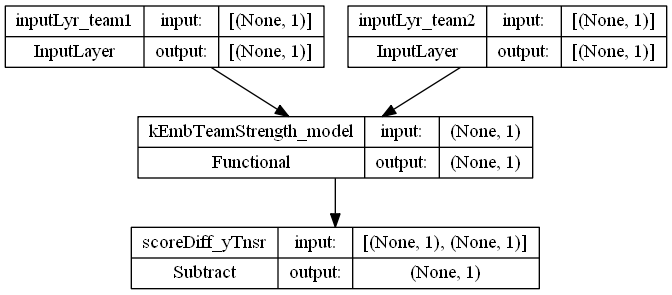

In [124]:
## repeated for clarity
## input tensr lyrs for team 1 & 2 resp
inputTeam1Tnsr1 = klyr.Input( shape= (1,), name= 'inputLyr_team1' )
inputTeam2Tnsr2 = klyr.Input( shape= (1,), name= 'inputLyr_team2' )
embTeamStrength_Tnsr1 = kEmbTeamStrength_model( inputTeam1Tnsr1 )
embTeamStrength_Tnsr2 = kEmbTeamStrength_model( inputTeam2Tnsr2)
# Create a subtract layer using the inputs from the our team dataset
scoreDiff_yTnsr = klyr.Subtract( name= 'scoreDiff_yTnsr' )( [ embTeamStrength_Tnsr1, embTeamStrength_Tnsr2 ] )

## new from here
## create the model
kSharedMerged_model = keras.models.Model(  inputs=  [ inputTeam1Tnsr1, inputTeam2Tnsr2 ], outputs= scoreDiff_yTnsr,
                                           name= 'kSharedMerged_model'  )

kSharedMerged_model.compile(  optimizer= 'adam', loss= 'mean_absolute_error'  )
kSharedMerged_model.summary(); keras.utils.plot_model( kSharedMerged_model, show_shapes= True,  show_layer_activations= True )

<h3><p style= text-align:left;'>Keras - Shared --> Merged --> Model</p></h3>
<img src= 'images/keras-sharedMerged-models.jpg' style= 'width:1703px;height:334px;'>
<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

<br>
<div id= '6.2.7'>
</div>

### 6.2.7 Predict from shared merged model

Key Concepts

    Keras models can handle multiple inputs, similar to single-input models.
    The fit, evaluate, and predict methods work the same for both multiple and single-input models.
    Multiple inputs require providing lists of inputs instead of single inputs.

Fitting with Multiple Inputs

    Provide a list of inputs with a length matching the number of model inputs.
    In our example, maintain a single target for training, even with multiple inputs.

Predicting with Multiple Inputs

    Convert input values to 2D NumPy arrays.
    Pass the input list to the model's predict() method.
    The model outputs the predicted result.

Evaluating with Multiple Inputs

    Provide a list of inputs and a single output.

[Go to top](#toc)

In [39]:
sgame_df = pd.read_csv( 'datasets/games_season.csv' )
print( sgame_df.shape );  sgame_df.head()

(312178, 8)


,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [1]:
kSharedMerged_model_fitHist =  kSharedMerged_model.fit(  x= [ sgame_df['team_1'], sgame_df['team_2'] ],
                                                         y= sgame_df['score_diff'],
                                                         epochs= 300, batch_size= 2048, validation_split=10./100, verbose= 2   )

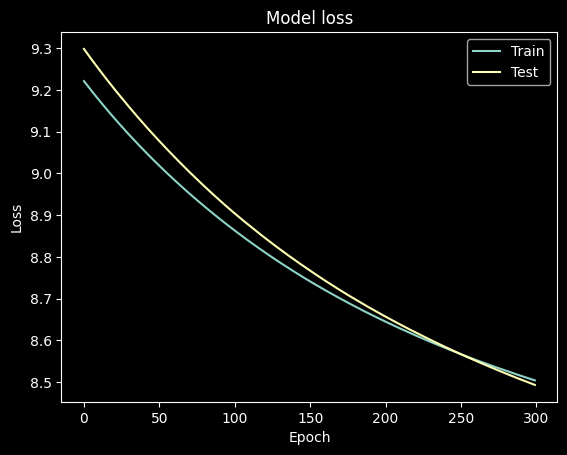

In [74]:
plt.style.use( 'dark_background' )
from utils import utils_data_analytics as u_da
# u_da.plot_model_loss( kSharedMerged_model_fitHist )
plot_model_loss( kSharedMerged_model_fitHist )

<br>

## Two Input Networks Using Categorical Embeddings, Shared Layers, & Merge Layers


### Three - Input model
Building and Training 3-Input Models with Keras

    Creating a 3-Input Model:
        Define 3 separate input layers.
        Utilize a Concatenate layer to merge the inputs.
        Employ a Dense layer to reduce the 3 inputs to 1 output.

    Incorporating Shared Layers in 3-Input Models:
        Pass the first two inputs to a shared layer.
        Concatenate the output of the shared layer with the third input.

    Fitting and Evaluating 3-Input Models:
        Compile the model with a loss function and an optimizer.
        Provide a list of three input columns and one output during fitting.
        Supply three inputs in a list and one output when evaluating.


In [126]:
## input tnsr lyrs for team 1 & 2 resp
inputTeam1Tnsr1 = klyr.Input(  shape= (1,), name= 'inputLyr_team1'  )
inputTeam1Tnsr2 = klyr.Input(  shape= (1,), name= 'inputLyr_team2'  )
# input tnsr for home vs away
inputHomeTnsr = klyr.Input(  shape= (1,), name= 'inputLyr_home'  )
# Lookup the team inputs in the kEmbTeamStrength_model
embTeamStrength_Tnsr1 = kEmbTeamStrength_model( inputTeam1Tnsr1 )
embTeamStrength_Tnsr2 = kEmbTeamStrength_model( inputTeam1Tnsr2 )
# Combine the team strengths tnsrs with the home input tnsr using a Concatenate layer, then add a Dense layer
yTnsr_concat = klyr.Concatenate()(  [ inputTeam1Tnsr1, inputTeam1Tnsr2, inputHomeTnsr ]  )
yTnsr = klyr.Dense(1)( yTnsr_concat )

<h3><p style= text-align:left;'>Concat Layers</p></h3>
<img src= 'images/concat_Tnsr_lyrs.png' style= 'width:1490px;height:379px;'>
<!-- m, wd, ht = 2, 2980, 758; ( wd/m, ht/m  ) -->

In [129]:
kSharedMergedConcat_model = keras.models.Model(  inputs= [ inputTeam1Tnsr1, inputTeam1Tnsr2, inputHomeTnsr],
                                                 outputs= yTnsr  )
kSharedMergedConcat_model.compile( optimizer= 'adam', loss= 'mean_absolute_error' )

Model: "kEmbTeamStrength_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GeneralInputTnsr (InputLaye  [(None, 1)]              0         
 r)                                                              
                                                                 
 teamStrength_embdLyr (Embed  (None, 1, 1)             10888     
 ding)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 1)                 0         
                                                                 
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


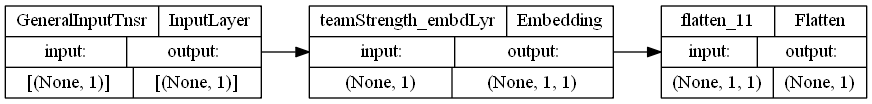

In [136]:
kEmbTeamStrength_model.summary()
keras.utils.plot_model( kEmbTeamStrength_model, show_shapes= True, show_layer_activations= True, expand_nested= True, rankdir='LR',
                        )

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLyr_team1 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 inputLyr_team2 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 inputLyr_home (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 3)            0           ['inputLyr_team1[0][0]',         
                                                                  'inputLyr_team2[0][0]',   

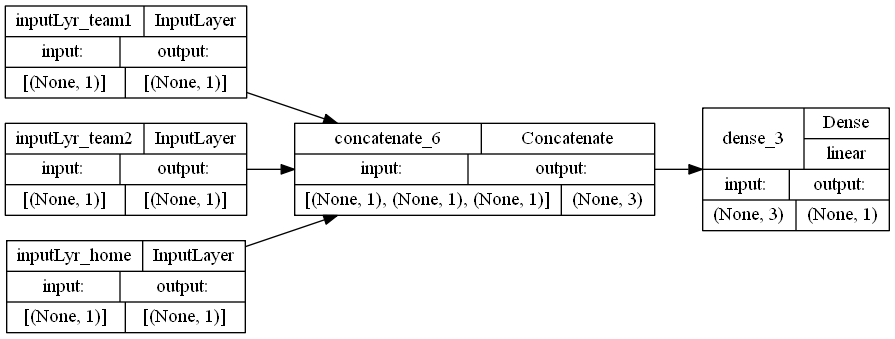

In [130]:
kSharedMergedConcat_model.summary();
keras.utils.plot_model( kSharedMergedConcat_model, show_shapes= True, show_layer_activations= True, expand_nested= True, rankdir='LR',
                        )

#### Fit the model and evaluate

In [2]:
xx = [  sgame_df['team_1'], sgame_df['team_2'], sgame_df['home']  ]
kSharedMergedConcat_modelHist = \
    kSharedMergedConcat_model.fit(  x= xx, y= sgame_df['score_diff'],
                                    epochs= 400, verbose= 2, validation_split= 20./100, batch_size= 2048  )

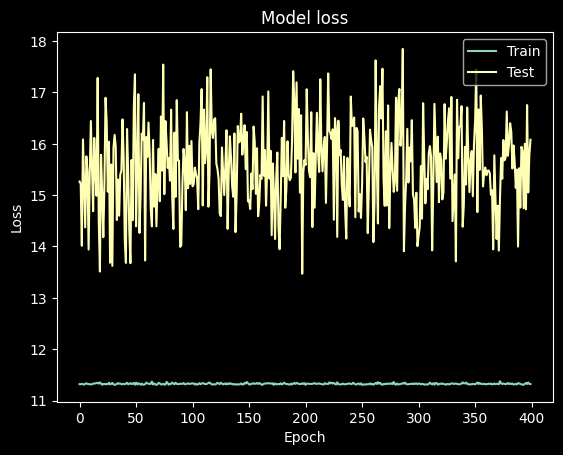

In [99]:
plt.style.use( 'dark_background' )
from utils import utils_data_analytics as u_da
# u_da.plot_model_loss( kSharedMerged_model_fitHist )
plot_model_loss( kSharedMergedConcat_modelHist )

In [102]:
# Evaluate the model on the games_tourney dataset
print(
kSharedMergedConcat_model.evaluate(  x= [ sgame_df['team_1'], sgame_df['team_2'], sgame_df['home'] ],
                                     y= sgame_df['score_diff'], verbose= 2  )
)

9756/9756 - 6s - loss: 12.2569 - 6s/epoch - 608us/step
12.256895065307617


In [139]:
i = 312177
kSharedMergedConcat_model.predict( x= [ sgame_df['team_1'].iloc[[i]], sgame_df['team_2'].iloc[[i]], sgame_df['home'].iloc[[i]] ] )
y_ls = kSharedMergedConcat_model.predict( x= [ sgame_df['team_1'], sgame_df['team_2'], sgame_df['home'] ] )
# sgame_df['team_1'].iloc[[i]]

 294/9756 [..............................] - ETA: 6s

9756/9756 [==============================] - 6s 580us/step


In [142]:
sgame_df

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1
...,...,...,...,...,...,...,...,...
312173,2018,3592,1481,1,-1,55,56,0
312174,2018,7322,2081,1,-1,57,58,0
312175,2018,9730,3233,1,-13,61,74,0
312176,2018,8813,4297,1,-5,72,77,0


In [143]:
kSharedMergedConcat_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLyr_team1 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 inputLyr_team2 (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 inputLyr_home (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 3)            0           ['inputLyr_team1[0][0]',         
                                                                  'inputLyr_team2[0][0]',   

<br>

## Multiple Outputs


### Two output models

Simple two-output model

We will use the tournament data to build one model that makes two predictions: the scores of both teams in a given game. The inputs will be the seed difference of the two teams, as well as the predicted score difference from the model we built in last chapter.

The output from the model will be the predicted score for team 1 as well as team 2. This is called `multiple target regression`: one model making more than one prediction.

In [161]:
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  sgame_df.drop( columns= ['score_1', 'score_2'] ),
                                                                    sgame_df[ ['score_1', 'score_2'] ],
                                                                    test_size= 20./100, random_state= 10                 
                         )
print( f"""
x -->  {xtrn.shape}\n{xtrn.head(2)}\n\n
y -->  {ytrn.shape}\n{ytrn.head(2)}
""")


x -->  (249742, 6)
        season  team_1  team_2  home  score_diff  won
157408    1985    8371    4839     1         -14    0
106132    2009    5605    8838     1          21    1


y -->  (249742, 2)
        score_1  score_2
157408       57       71
106132       94       73



In [3]:
ipTnsr = klyr.Input(  shape= (xtrn.shape[-1],)  )
denseLyr1 = klyr.Dense( 500 )( ipTnsr )
denseLyr2 = klyr.Dense( 250 )( denseLyr1 )
denseLyr3 = klyr.Dense( 100 )( denseLyr2 )
denseLyr4 = klyr.Dense( 50 )( denseLyr3 )
denseLyr5 = klyr.Dense( 25 )( denseLyr4 )
denseLyr6 = klyr.Dense( 10 )( denseLyr5 )
denseLyr7 = klyr.Dense( 5 )( denseLyr6 )
opTnsr = klyr.Dense( 2 )( denseLyr7 )

regModel = keras.models.Model( inputs= ipTnsr, outputs= opTnsr )
regModel.compile( optimizer= 'adam', loss= 'mean_squared_error' )
regModel.fit(  x= xtrn, y= ytrn, epochs= 25, batch_size= 16384, verbose= 2, validation_data= (xtst, ytst)  )

#### plots for losses

<Axes: >

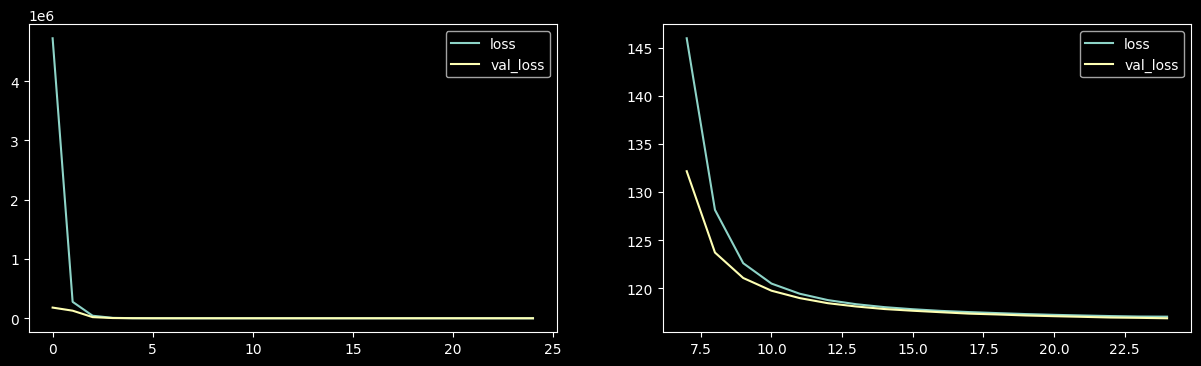

In [237]:
fg, ax = plt.subplots( 1,2, figsize= (15, 4) )

loss_df = pd.DataFrame( regModel.history.history )
loss_df[ ['loss','val_loss'] ].plot( ax= ax[0] )
loss_df.loc[ loss_df['loss']<=150, ['loss','val_loss'] ].plot( ax= ax[1] )

In [248]:
yhat_tst = pd.DataFrame( regModel.predict( xtst ), columns=  ytst.columns )
yhat_ytst = pd.concat(  [ yhat_tst, ytst.reset_index(drop=True) ], axis= 1 )
yhat_ytst.columns= [ 'yhat_s1', 'yhat_s2', 'ytst_s1', 'ytst_s2' ]
yhat_ytst.head(3)

 241/1952 [==>...........................] - ETA: 1s

1952/1952 [==============================] - 2s 1ms/step


,yhat_s1,yhat_s2,ytst_s1,ytst_s2
0,65.834236,75.640266,56,66
1,73.822929,66.888466,72,65
2,69.440437,71.299194,86,88


<Axes: >

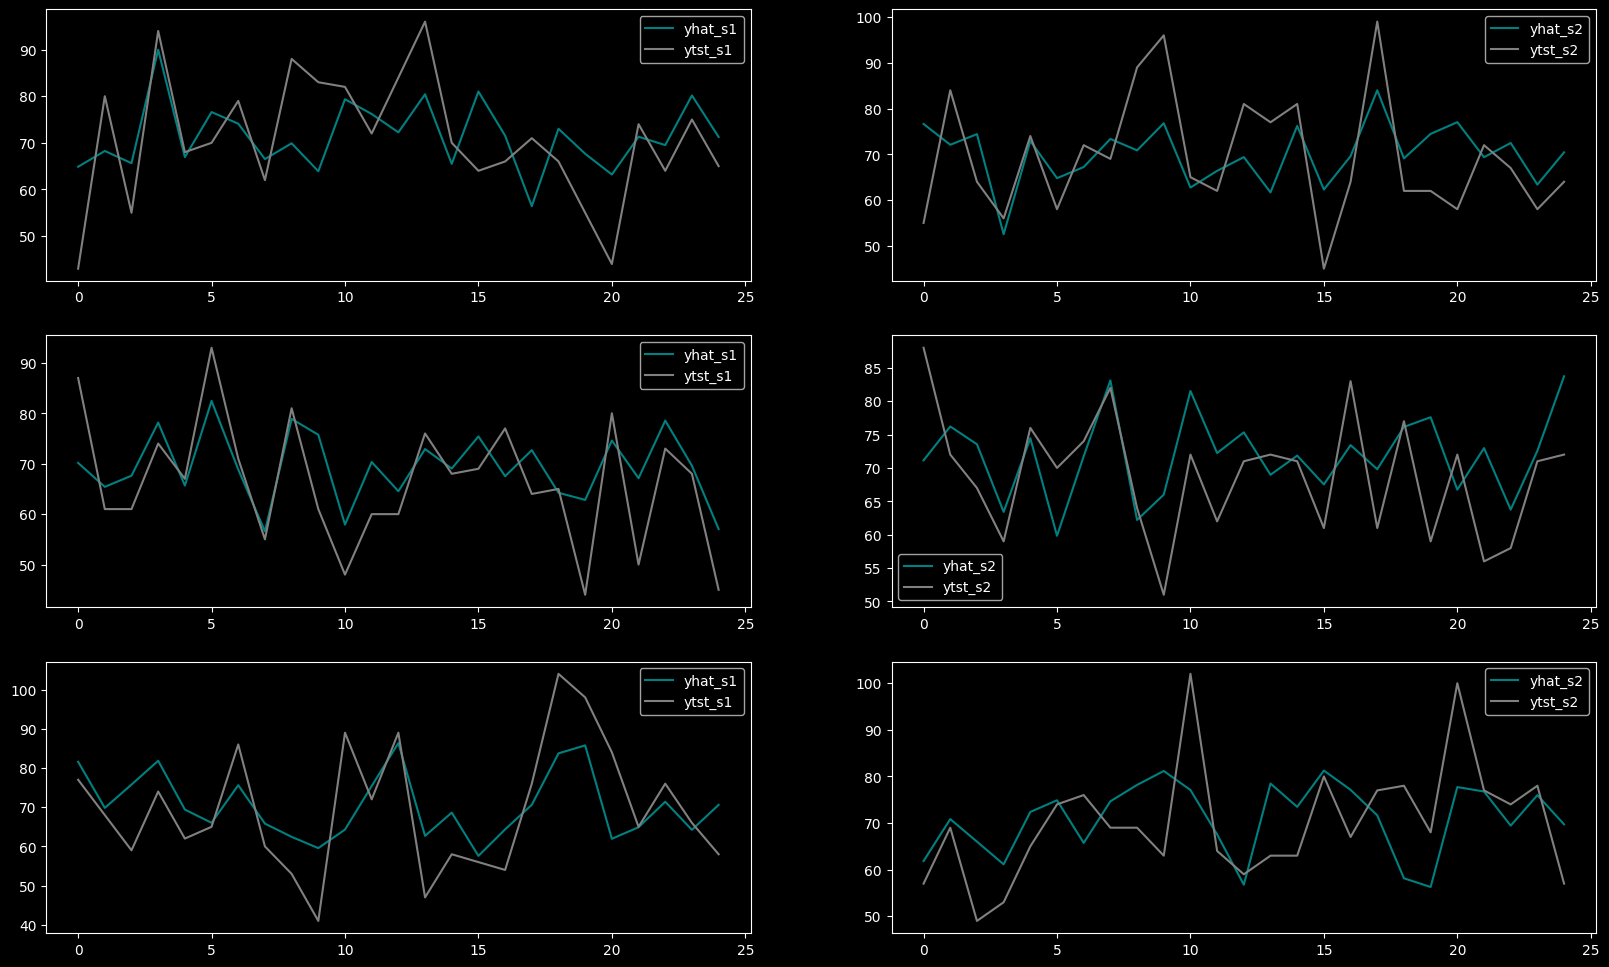

In [278]:
fg, ax = plt.subplots( 3,2, figsize= (20, 12) )

yhat_tst_sample1 = yhat_ytst.sample( frac= 0.04/100, random_state= 10 ).reset_index(drop=True)
yhat_tst_sample2 = yhat_ytst.sample( frac= 0.04/100, random_state= 20 ).reset_index(drop=True)
yhat_tst_sample3 = yhat_ytst.sample( frac= 0.04/100, random_state= 30 ).reset_index(drop=True)

yhat_tst_sample1[ ['yhat_s1','ytst_s1'] ].plot( ax= ax[0][0], color= ('teal', 'gray') )
yhat_tst_sample1[ ['yhat_s2','ytst_s2'] ].plot( ax= ax[0][1], color= ('teal', 'gray') )

yhat_tst_sample2[ ['yhat_s1','ytst_s1'] ].plot( ax= ax[1][0], color= ('teal', 'gray') )
yhat_tst_sample2[ ['yhat_s2','ytst_s2'] ].plot( ax= ax[1][1], color= ('teal', 'gray') )

yhat_tst_sample3[ ['yhat_s1','ytst_s1'] ].plot( ax= ax[2][0], color= ('teal', 'gray') )
yhat_tst_sample3[ ['yhat_s2','ytst_s2'] ].plot( ax= ax[2][1], color= ('teal', 'gray') )

In [244]:
loss_df['loss'].min(), regModel.evaluate( xtst, ytst )

 230/1952 [==>...........................] - ETA: 1s - loss: 117.3422

1952/1952 [==============================] - 2s 1ms/step - loss: 116.8763


(117.04337310791016, 116.87626647949219)

<br><br>

### Single model for `Regression` & `Classification`

[Go to top](#toc)

When building a simple model for Classification & Regression

        The model has two outputs: a regression output & a classification output.
        The regression output predicts --> score difference between the two teams.
        The classification output predicts --> whether or not team 1 will win the game.
        
Make a regressor/classifier model

        The regression part of the model is a Dense layer with a single unit.
        The classification part of the model is a Dense layer with a `sigmoid activation` function.

Fit the combination classifier/regressor

        The regression output is trained using the score difference between the two teams.
        The classification output is trained using whether or not team 1 won the game.

Interpretating the model's weights (Regressor)

        Assume the weight of the first layer is 1.3 and the bias is almost zero.
        This means that a 1 unit change in the teams' seed difference yields about 1.3 additional points in their score difference.

Interpretating the model's weights (Classifier)

        Assume the weight of the final layer is 0.14 and the bias is 0.007.
        This means that an expected score difference of 1 point is equal to an expected win probability of scipy.special.expit( 1*.14 + .007 ) = 0.54 = 54%


In [297]:
tour_df = pd.read_csv( 'datasets/games_tourney.csv' )
print( tour_df.shape ); tour_df.head(3)

(4234, 9)


,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0


In [299]:
xx = tour_df[ ['season', 'team_1', 'team_2', 'home', 'seed_diff'] ]
y_reg = tour_df[ ['score_diff'] ]
y_class = tour_df[ ['won'] ]

In [300]:
print( f"""
x -->\n{xx.head()}\n\n
y_reg -->\n{y_reg.head()}\n\n
y_class -->\n{y_class.head()}
""" )


x -->
   season  team_1  team_2  home  seed_diff
0    1985     288      73     0         -3
1    1985    5929      73     0          4
2    1985    9884      73     0          5
3    1985      73     288     0          3
4    1985    3920     410     0          1


y_reg -->
   score_diff
0          -9
1           6
2          -4
3           9
4          -9


y_class -->
   won
0    0
1    1
2    0
3    1
4    0



In [303]:
ipTnsr = klyr.Input( shape= (xx.shape[-1],) )
opTnsr_Reg = klyr.Dense(  1, activation= 'linear'  )( ipTnsr )
opTnsr_Class = klyr.Dense(  1, activation= 'sigmoid'  )( opTnsr_Reg )

model_RegClass = keras.models.Model(  inputs= ipTnsr, outputs= [ opTnsr_Reg, opTnsr_Class ]  )

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
 dense_36 (Dense)            (None, 1)                 2         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


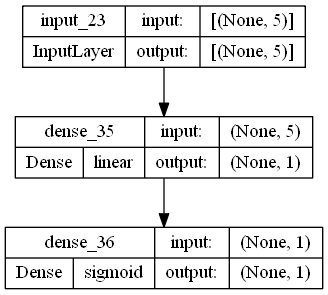

In [306]:
model_RegClass.summary()
keras.utils.plot_model( model_RegClass, show_shapes= True, show_layer_activations= True, expand_nested= True )

In [4]:
model_RegClass.compile(  loss= ['mean_absolute_error', 'binary_crossentropy'],
                         optimizer= keras.optimizers.Adam(learning_rate=0.01)  )
model_RegClass.fit(  x= xx, y= [ y_reg, y_class ], epochs= 1000, verbose= 2   )

<Axes: >

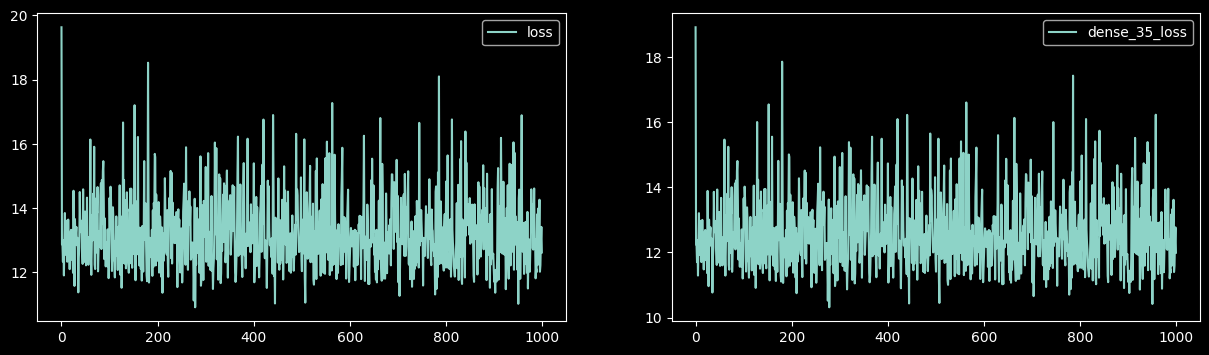

In [321]:
model_RegClass.history.history

fg, ax = plt.subplots( 1,2, figsize= (15, 4) )

loss_df = pd.DataFrame( model_RegClass.history.history )
loss_df
loss_df[ ['loss'] ].plot( ax= ax[0] )
loss_df[ ['dense_35_loss'] ].plot( ax= ax[1] )
loss_df[ ['dense_35_loss'] ].plot( ax= ax[1] )

#### DNN

In [322]:
ipTnsr = klyr.Input( shape= (xx.shape[-1],) )

denseLyr1 = klyr.Dense( 500 )( ipTnsr )
denseLyr2 = klyr.Dense( 100 )( denseLyr1 )
denseLyr3 = klyr.Dense( 25 )( denseLyr2 )
denseLyr4 = klyr.Dense( 10 )( denseLyr3 )
denseLyr5 = klyr.Dense( 5 )( denseLyr4 )
opTnsr_Reg = klyr.Dense(  1, activation= 'linear'  )( denseLyr5 )
opTnsr_Class = klyr.Dense(  1, activation= 'sigmoid'  )( opTnsr_Reg )

model_RegClass = keras.models.Model(  inputs= ipTnsr, outputs= [ opTnsr_Reg, opTnsr_Class ]  )

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_37 (Dense)            (None, 500)               3000      
                                                                 
 dense_38 (Dense)            (None, 100)               50100     
                                                                 
 dense_39 (Dense)            (None, 25)                2525      
                                                                 
 dense_40 (Dense)            (None, 10)                260       
                                                                 
 dense_41 (Dense)            (None, 5)                 55        
                                                                 
 dense_42 (Dense)            (None, 1)                 6  

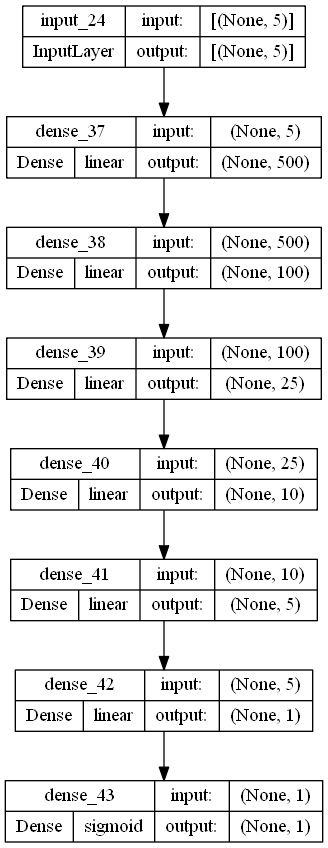

In [324]:
model_RegClass.summary()
keras.utils.plot_model( model_RegClass, show_shapes= True, show_layer_activations= True, expand_nested= True )

In [5]:
model_RegClass.compile(  loss= ['mean_absolute_error', 'binary_crossentropy'],
                         optimizer= keras.optimizers.Adam(learning_rate=0.01)  )
model_RegClass.fit(  x= xx, y= [ y_reg, y_class ], epochs= 200, verbose= 2   )
loss_df = pd.DataFrame( model_RegClass.history.history )

<Axes: >

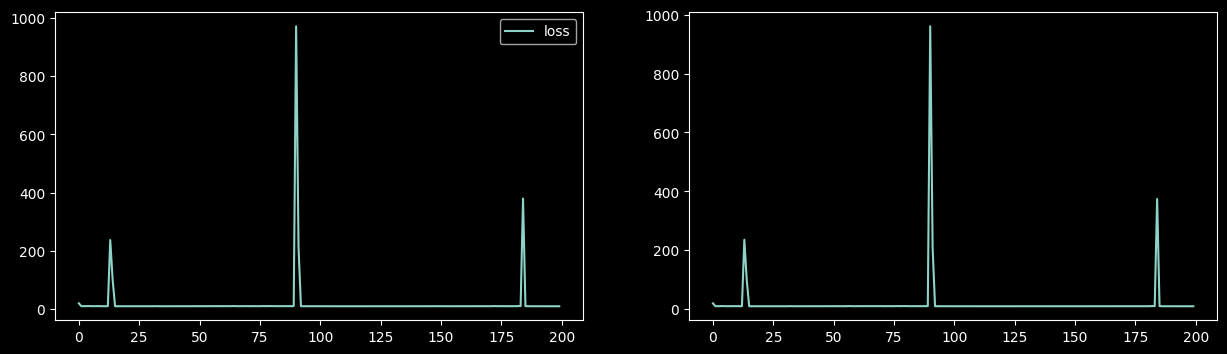

In [340]:
model_RegClass.history.history

fg, ax = plt.subplots( 1,2, figsize= (15, 4) )

loss_df.loc[ :, ['loss'] ].plot( ax= ax[0] )
loss_df.iloc[ :, 1 ].plot( ax= ax[1] )

In [342]:
print(  model_RegClass.evaluate( x= xx, y= [y_reg,y_class] )  )

 42/133 [========>.....................] - ETA: 0s - loss: 9.5415 - dense_42_loss: 8.9919 - dense_43_loss: 0.5496 

133/133 [==============================] - 0s 1ms/step - loss: 9.7298 - dense_42_loss: 9.1741 - dense_43_loss: 0.5557
[9.729790687561035, 9.174067497253418, 0.5557233095169067]
